In [16]:
import numpy as np
import jax
from jax import jit, vmap
from jax.flatten_util import ravel_pytree
import jax.numpy as jnp

import blackjax
from blackjax.vi.svgd import SVGDState

import optax

import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from jax import config
config.update("jax_enable_x64",True)

In [7]:
def gaussian_mixture(x, mu1=-2, mu2=2):
    pdf = lambda x, mu: jax.scipy.stats.norm.pdf(x, loc=mu, scale=1)
    return (1/3)*pdf(x, mu1) + (2/3)*pdf(x, mu2)

def gaussian_mixture_log_pdf(x):
    return jnp.log(gaussian_mixture(x))

In [8]:
@jit
def rbf_kernel(x, y, length_scale=1):
    arg = ravel_pytree(jax.tree_util.tree_map(lambda x, y: (x - y) ** 2, x, y))[0]
    return jnp.exp(-(1 / length_scale) * arg.sum())

@jit
def median_heuristic(kernel_parameters, particles):
    particle_array = jax.vmap(lambda p: ravel_pytree(p)[0])(particles)

    def distance(x, y):
        return jnp.linalg.norm(jnp.atleast_1d(x - y))

    vmapped_distance = jax.vmap(jax.vmap(distance, (None, 0)), (0, None))
    A = vmapped_distance(particle_array, particle_array)  # Calculate distance matrix
    pairwise_distances = A[
        jnp.tril_indices(A.shape[0], k=-1)
    ]  # Take values below the main diagonal into a vector
    median = jnp.median(pairwise_distances)
    kernel_parameters["length_scale"] = (median**2) / jnp.log(particle_array.shape[0])
    return kernel_parameters


def update_median_heuristic(state: SVGDState) -> SVGDState:
    """Median heuristic for setting the bandwidth of RBF kernels.

    A reasonable middle-ground for choosing the `length_scale` of the RBF kernel
    is to pick the empirical median of the squared distance between particles.
    This strategy is called the median heuristic.
    """

    position, kernel_parameters, opt_state = state
    return SVGDState(position, median_heuristic(kernel_parameters, position), opt_state)

In [9]:
def svgd_training_loop(
    log_p,
    initial_position,
    initial_kernel_parameters,
    kernel,
    optimizer,
    *,
    num_iterations=500,
):
    svgd = blackjax.svgd(jax.grad(log_p), optimizer, kernel, update_median_heuristic)
    state = svgd.init(initial_position, initial_kernel_parameters)
    step = jax.jit(svgd.step)  # type: ignore[attr-defined]

    for _ in range(num_iterations):
        state = step(state)
    return state

We define the posterior distribution

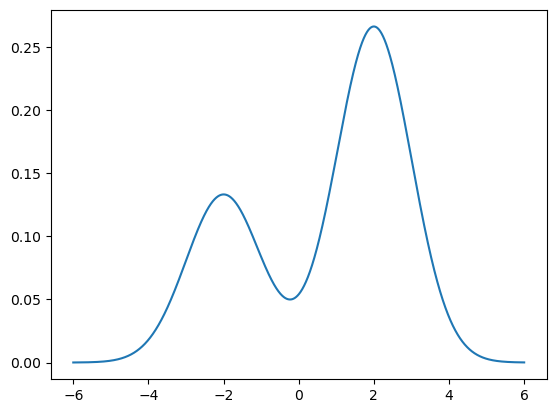

In [10]:
fig = plt.figure()
ax = fig.subplots()
x = jnp.linspace(-6, 6, 10000)
sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax);

The distribution of the initial particles is shown below:

<Axes: ylabel='Density'>

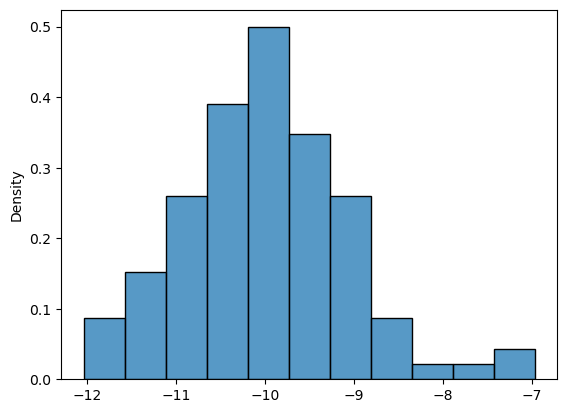

In [20]:
num_particles = 100

# Sample initial particles from a (-10, 1) normal distribution
initial_particles = (-10) + jax.random.normal(
        jax.random.PRNGKey(3),
        shape=(num_particles,)
        )

fig = plt.figure()
ax = fig.subplots()
sns.histplot(initial_particles, ax=ax, stat="density")

Intial particles plotted agains posterior distribution

<Axes: ylabel='Density'>

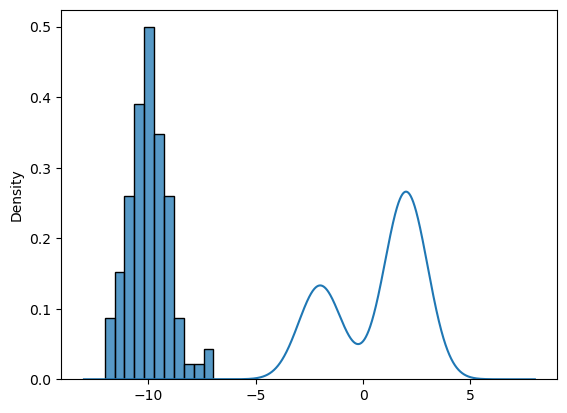

In [23]:
fig = plt.figure()
ax = fig.subplots()
x = jnp.linspace(-13, 8, 10000)
sns.histplot(initial_particles, ax=ax, stat="density")
sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax)

SVGD algorithm

In [24]:
# Run the algorithm
out = svgd_training_loop(
    initial_position = initial_particles,
    initial_kernel_parameters=median_heuristic({"length_scale": 1}, initial_particles),
    log_p = gaussian_mixture_log_pdf,
    kernel=rbf_kernel,
    optimizer=optax.adam(0.3),
    num_iterations=500,
    )

Below we can see that particles are pushed towards the desired distribution

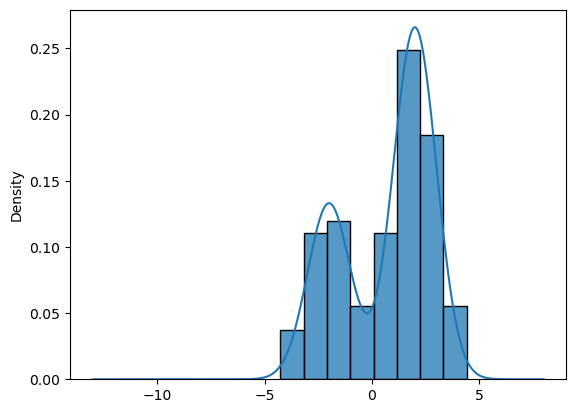

In [25]:
# Plot the results
def plot(particles):
    fig = plt.figure()
    ax = fig.subplots()
    x = jnp.linspace(-13, 8, 10000)
    sns.histplot(particles, ax=ax, stat="density")
    #sns.histplot(initial_particles, ax=ax, stat="density")
    sns.lineplot(y=vmap(gaussian_mixture)(x), x=x, ax=ax)
    #plt.xlim([-13, 8]);
    # plt.show()
plot(out.particles)

Estimated expectation is close to True expectation

In [26]:
print(f"Estimated expectation: {out.particles.mean()}")
print(f"True expectation: {2/3}")

Estimated expectation: 0.6175753117870522
True expectation: 0.6666666666666666
